# **Problem Statement**

Kekhawatiran adanya keterlambatan pembayaran kartu kredit pada FinanKu yang akan merugikan bisnis.
Sehingga orang-orang yang memiliki potensi untuk mengalami keterlambatan bayar bisa diprediksi lebih cepat untuk menentukan strategi yang sesuai dalam menghadapi kondisi di masa mendatang.

# **Objective**

Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit (Accuracy dan Recall > 60%).

# **Variabel yang tersedia**

Dari dataset yang dimiliki terdapat beberapa data yang tersedia:

1. **Customer ID**: unique ID customer.
2. **Branch**: lokasi cabang nasabah terdaftar.
3. **City**: lokasi kota nasabah terdaftar.
4. **Age**: umur nasabah pada periode observasi.
5. **Avg. Annual Income**: rata-rata penghasilan nasabah dalam satu tahun.
6. **Balance (Q1-Q4)**: saldo mengendap yang dimiliki nasabah di akhir kuartal.
7. **Num of Product (Q1-Q4)**: jumlah kepemilikan produk nasabah yang dimiliki di akhir kuartal.
8. **HasCrCard (Q1-Q4)**: status kepemilikan produk kartu kredit nasabah di akhir kuartal.
9. **Active Member (Q1-Q4)**: status keaktifan nasabah.
10. **Unpaid tagging**: status nasabah gagal bayar.

# **Experiment**

Periode tinjauan:
1. Nasabah di-review selama satu tahun terakhir.
2. Nasabah di-review selama 6 bulan terakhir.

Penyesuaian variabel:
1. Balance dilihat dari rata-rata selama horizon waktu dan dilihat perubahan pada akhir tinjauan dan awal tinjauan.
2. Melihat kepemilikan jumlah produk dari rata-rata, maksimum, dan minimum pada periode tinjauan.
3. Status keaktifan nasabah dilihat dalam bentuk bulan.

# **Code**

## **Import Package**

In [80]:
pip install jcopml

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from jcopml.feature_importance import mean_score_decrease

In [82]:
pd.set_option('display.max_columns', None)

## **Data For Prediction**

In [83]:
path_1 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path_2 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

Dataset untuk eksperimen 1

In [84]:
df1 = pd.read_csv(path_1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


Dataset untuk eksperimen 2

In [85]:
df2 = pd.read_csv(path_1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


## **Data Understanding**

Sebaran nasabah berdasarkan lokasi:
- Sebaran keseluruhan.
- Sebaran nasabah gagal bayar.

In [86]:
data1 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Kota
                     df_all.groupby(by=["City"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mengurutkan data
                     .sort_values(ascending=False)\
                     #Mereset nama header
                     .reset_index(name='Distribution by City'))
data1

,City,Distribution by City
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [87]:
data2 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Kota
                     df_all[df_all["Unpaid Tagging"]==1].groupby(by=["City"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mengurutkan data
                     .sort_values(ascending=False)\
                     #Mereset nama header
                     .reset_index(name='Distribution by City'))
data2

,City,Distribution by City
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


Sebaran nasabah berdasarkan usia:
- Sebaran keseluruhan.
- Sebaran nasabah gagal bayar.

<Axes: title={'center': 'Customer Distribution by Age'}, xlabel='Age', ylabel='# People'>

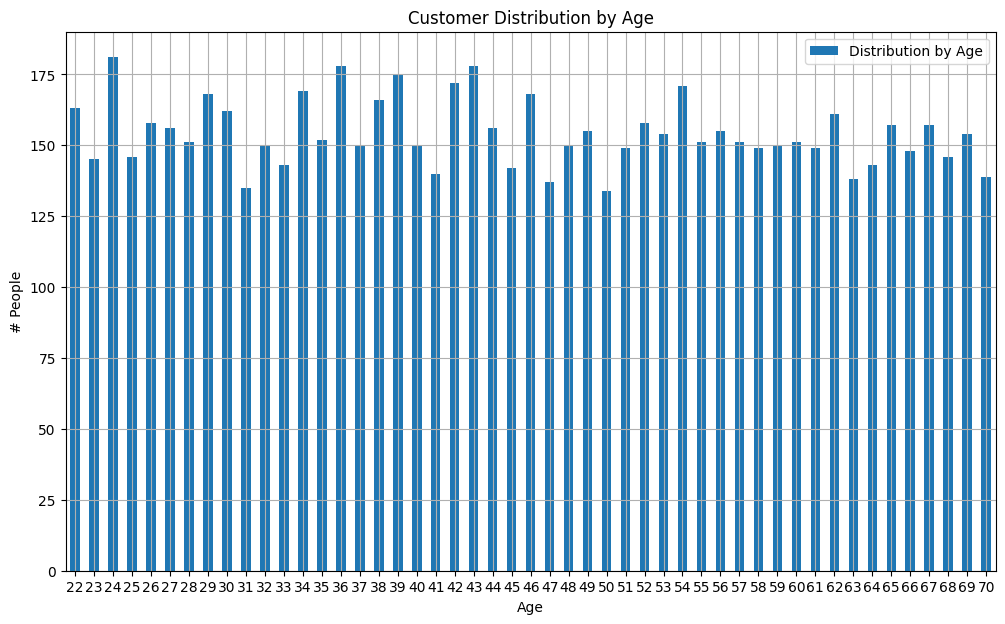

In [88]:
data3 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Umur
                     df_all.groupby(by=["Age"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mereset nama header
                     .reset_index(name='Distribution by Age'))

data3.sort_values(\
                  by=['Age'], \
                  ascending=True,\
                  inplace=True)


data3.plot(
    x='Age',
    y='Distribution by Age',
    kind='bar',
    grid=True,
    xlabel='Age',
    ylabel='# People',
    figsize=(12, 7),
    rot=0,
    title='Customer Distribution by Age'
)

<Axes: title={'center': 'Unpaid Customer Distribution by Age'}, xlabel='Age', ylabel='# People'>

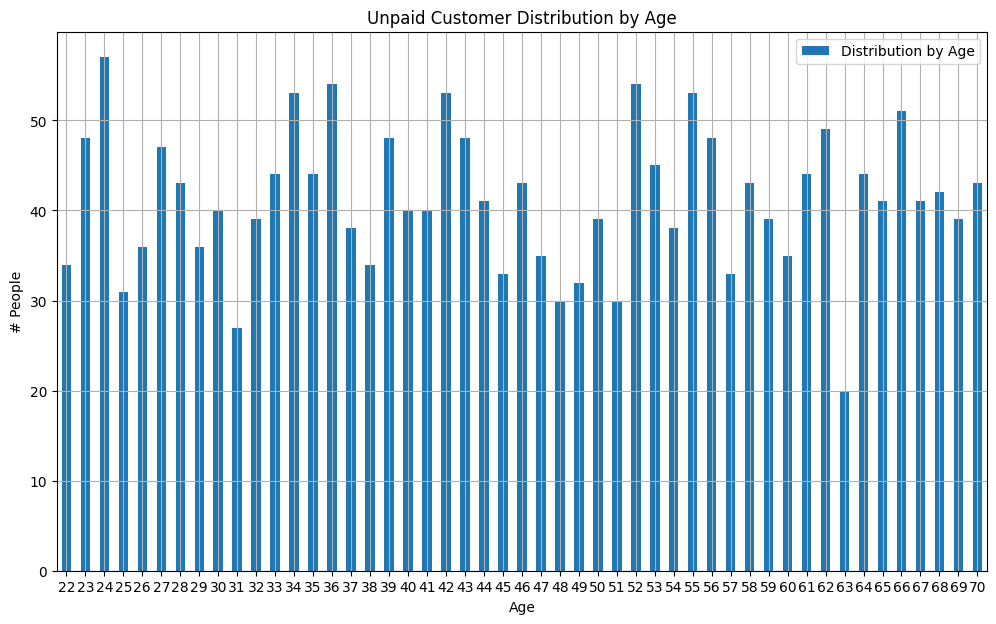

In [89]:
data4 = pd.DataFrame(\
                     #Mengkelompokkan Berdasarkan Umur
                     df_all[df_all["Unpaid Tagging"]==1].groupby(by=["Age"])["Customer ID"]\
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()\
                     #Mereset nama header
                     .reset_index(name='Distribution by Age'))

data4.sort_values(\
                  by=['Age'], \
                  ascending=True,\
                  inplace=True)


data4.plot(
    x='Age',
    y='Distribution by Age',
    kind='bar',
    grid=True,
    xlabel='Age',
    ylabel='# People',
    figsize=(12, 7),
    rot=0,
    title='Unpaid Customer Distribution by Age'
)

Rata-rata saldo nasabah

In [90]:
df_checkbalance = df_all

In [91]:
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4'])/4

In [92]:
data5 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Total Balance"]\
                     .mean()\
                     .reset_index(name='Avg Annual Balance'))
data5

,Unpaid Tagging,Avg Annual Balance
0,0,1.985924e+08
1,1,2.527238e+08


In [93]:
data6 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Balance"]\
                     .mean()\
                     .reset_index(name='Avg Quarterly Balance'))
data6

,Unpaid Tagging,Avg Quarterly Balance
0,0,4.964809e+07
1,1,6.318095e+07


Rata-rata kepemilikan produk

In [94]:
df_checkbalance['Avg Product'] = (df_checkbalance['NumOfProducts Q1']+df_checkbalance['NumOfProducts Q2']+df_checkbalance['NumOfProducts Q3']+df_checkbalance['NumOfProducts Q4'])/4

In [95]:
data7 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Product"]\
                     .mean()\
                     .reset_index(name='Avg Product Owned'))
data7

,Unpaid Tagging,Avg Product Owned
0,0,1.667223
1,1,1.609336


In [96]:
df_all = df_all.drop(columns=['Total Balance', 'Avg Balance','Avg Product'])

## **Data Preparation**

### Pengecekan Duplikat Data dan Missing Data

In [97]:
df_all.duplicated().sum()

0

In [98]:
df_all.isnull().sum()

,0
Customer ID,0
Branch Code,0
City,0
Age,0
Avg. Annual Income/Month,0
Balance Q1,0
NumOfProducts Q1,0
HasCrCard Q1,0
ActiveMember Q1,0
Balance Q2,0


### Penambahan Variabel Relevan

**Rata-rata saldo dan perubahan saldo selama periode observasi**

Melihat saldo nasabah dalam lingkup observasi.
1. Eksperimen 1: rata-rata saldo nasabah dalam 1 tahun terakhir dan perubahan saldo di Q4 terhadap Q1.
2. Eksperimen 2: rata-rata saldo nasabah dalam 6 bulan terakhir dan perubahan saldo di Q4 terhadap Q1.

Eksperimen 1

In [99]:
df1['Mean Balance'] = (df1['Balance Q1']+df1['Balance Q2']+df1['Balance Q3']+df1['Balance Q4'])/4
df1['Delta Balance'] = df1['Balance Q4']-df1['Balance Q1']

In [100]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68


Eksperimen 2

In [101]:
df2['Mean Balance'] = (df2['Balance Q3']+df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4']-df2['Balance Q2']

In [102]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68


**Status Keaktifan**

Melihat periode nasabah aktif dalam scope observasi

1. Experiment 1 --> Keaktifan nasabah (dalam bulan) di 1 tahun terakhir
2. Experiment 2 --> Keaktifan nasabah (dalam bulan) di 6 bulan terakh

Eksperimen 1

In [103]:
df1['Active Months'] = (df1['ActiveMember Q1']+df1['ActiveMember Q2']+df1['ActiveMember Q3']+df1['ActiveMember Q4'])*3

In [104]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6


Eksperimen 2

In [105]:
df2['Active Months'] = (df2['ActiveMember Q3']+df2['ActiveMember Q4'])*3

In [106]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6


### **Penambahan atau Pengurangan Product Holding**
Melihat fluktuasi kepemilikan produk nasabah dalam periode observasi.

Eksperimen 1

In [107]:
df1['Diff PH'] = df1['NumOfProducts Q4']-df1['NumOfProducts Q1']

In [108]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


Eksperimen 2

In [109]:
df2['Diff PH'] = df2['NumOfProducts Q4']-df1['NumOfProducts Q2']

In [110]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0


**Lama Kepemilikan Kartu Kredit dalam Periode Observasi**

In [111]:
def assign_cr1(df):
    if df['HasCrCard Q1'] == 1:
        return 12
    elif df['HasCrCard Q2'] == 1:
        return 9
    elif df['HasCrCard Q3'] == 1:
        return 6
    else:
        return 3
    return np.nan

Eksperimen 1

In [112]:
df1['Vintage_CR'] = df1.apply(assign_cr1, axis = 1)

In [113]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


Eksperimen 2

In [114]:
df2['Vintage_CR'] = df2.apply(assign_cr1, axis = 1)

In [115]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0,12


### **Penghapusan Variabel**

Status kepemilikan sudah digantikan dengan lama kepemilikan kartu kredit.

In [116]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])
df2 = df2.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])

Balance Per Quarter sudah digantikan dengan rata-rata saldo dalam periode observasi dan selisih saldo di awal dan akhir periode observasi.

In [117]:
df1 = df1.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])
df2 = df2.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])

Jumlah Kepemilikan Produk sudah digantikan dengan fluktuasi kepemilikan produk pada periode observasi.

In [118]:
df1 = df1.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])
df2 = df2.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])

Status Keaktifan Nasabah Per Quarter digantikan dengan Status Keaktifan dalam Bulan

In [119]:
df1 = df1.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2 = df2.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

## **Data Transformation**

### **Pemisahan Variabel Prediktor**

In [120]:
predictor1 = df1[df1.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [121]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [122]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,3,29,33000000,1001,Jakarta,1187036.18,0,593518.09,12
1,0,68,17000000,1005,Jakarta,0.00,0,0.00,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,675910.12,12
3,0,42,19000000,1008,Jakarta,0.00,0,0.00,12
4,6,43,29000000,1009,Jakarta,431190.68,0,555048.18,12


### **Melakukan Encoding untuk Data Category**

Kategori variabel:
1. Branch Code
2. City

Untuk branch code perlu diubah menjadi string agar dianggap sebagai data kategori.

In [123]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)

<ipython-input-123-b9748522fe9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
<ipython-input-123-b9748522fe9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


In [124]:
predictor1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [125]:
predictor2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


Kita ubah tipe data kategori menjadi variable indikator/dummy.

In [126]:
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)

In [127]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,68,17000000,0.00,0,0.000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,337955.060,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,3,42,19000000,0.00,0,0.000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,277524.090,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [128]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,593518.09,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.00,0,0.00,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,675910.12,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.00,0,0.00,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,555048.18,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [129]:
predname = predictor1.columns
predname_num = predictor1.columns[0:7] #mengambil kolom numerik
predname_cat = predictor1.columns[7:31] #mengambil kolom kategori

In [130]:
predname

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR', 'Branch Code_1001',
       'Branch Code_1002', 'Branch Code_1003', 'Branch Code_1004',
       'Branch Code_1005', 'Branch Code_1006', 'Branch Code_1007',
       'Branch Code_1008', 'Branch Code_1009', 'Branch Code_1011',
       'Branch Code_1012', 'Branch Code_1013', 'Branch Code_1014',
       'Branch Code_1015', 'Branch Code_1021', 'Branch Code_1022',
       'Branch Code_1023', 'Branch Code_1024', 'City_Bandung', 'City_Jakarta',
       'City_Surabaya'],
      dtype='object')

In [131]:
predname_num

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR'],
      dtype='object')

In [132]:
predname_cat

Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya'],
      dtype='object')

In [133]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat]

Standardisasi data numerik

In [134]:
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()
X1_num = pd.DataFrame(pt.fit_transform(X1_num))
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [135]:
X1_num.columns = predname_num
X1_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [136]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [137]:
X2_num.columns = predname_num
X2_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


### **Menggabungkan Dataset Prediktor**

In [138]:
X1 = pd.concat([X1_cat, X1_num], axis = 1)
X2 = pd.concat([X2_cat, X2_num], axis = 1)

In [139]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [140]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [141]:
#variabel dependen
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

### **Memproses Dataset untuk Validasi**

Proses ini mengulangi proses data preparation, tetapi menggunakan dataframe validation.

- **Import Data**

In [142]:
df1_val = pd.read_csv(path_2) #untuk eksperimen 1
df2_val = pd.read_csv(path_2) #untuk eksperimen 2

- **Penambahan Variabel Relevan**

Rata-rata balance dan perubahan saldo.

In [143]:
df1_val['Mean Balance'] = (df1_val['Balance Q3']+df1_val['Balance Q2']+df1_val['Balance Q5']+df1_val['Balance Q4'])/4
df1_val['Delta Balance'] = df1_val['Balance Q5'] - df1_val['Balance Q2']

In [144]:
df2_val['Mean Balance']= (df2_val['Balance Q4'] + df2_val['Balance Q5'])/2
df2_val['Delta Balance'] = df2_val['Balance Q5'] - df2_val['Balance Q3']

- **Status Keaktifan**

In [145]:
df1_val['Active Months'] = (df1_val['Balance Q3'] + df1_val['Balance Q2'] + df1_val['Balance Q5'] + df1_val['Balance Q4'])*3
df2_val['Mean Balance']= (df2_val['Balance Q4'] + df2_val['Balance Q5'])*3

- **Penambahan atau Pengurangan Product Holding**

In [146]:
df1_val['Diff PH'] = df1_val['Balance Q5'] - df1_val['Balance Q2']
df2_val['Diff PH'] = df2_val['Balance Q5'] - df2_val['Balance Q3']

- **Lama Kepemilikan Kartu Kredit**

In [147]:
def assign_cr2(df):
  if df['HasCrCard Q2'] == 1:
    return 12
  elif df['HasCrCard Q3'] == 1:
    return 9
  elif df['HasCrCard Q4'] == 1:
    return 6
  else:
    return 3
  return np.nan

In [148]:
df1_val['Vintage_CR'] = df1_val.apply(assign_cr2, axis = 1)
df2_val['Vintage_CR'] = df2_val.apply(assign_cr2, axis = 1)

- **Penghapusan Variabel**

In [149]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2_val = df2_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

In [150]:
df1_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,6.231940e+05,1.305740e+06,7.478328e+06,1.305740e+06,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12
2,15566091,1009,Jakarta,25,12000000,0,7.435011e+05,1.622184e+06,8.922014e+06,1.622184e+06,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12
4,15566312,1009,Jakarta,43,29000000,0,3.853218e+05,4.311907e+05,4.623861e+06,4.311907e+05,12
5,15566495,1005,Jakarta,27,15000000,0,5.647607e+07,1.365946e+07,6.777128e+08,1.365946e+07,12
6,15566543,1003,Jakarta,68,26000000,0,1.234332e+08,5.441502e+07,1.481198e+09,5.441502e+07,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,12
8,15566689,1003,Jakarta,43,38000000,0,2.247047e+05,2.996062e+05,2.696456e+06,2.996062e+05,12
9,15566958,1005,Jakarta,70,23000000,0,8.243379e+07,1.169147e+07,9.892055e+08,1.169147e+07,6


In [151]:
df2_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,7.478328e+06,1.305740e+06,1.305740e+06,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0.000000e+00,12
2,15566091,1009,Jakarta,25,12000000,0,8.922014e+06,1.622184e+06,1.622184e+06,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0.000000e+00,12
4,15566312,1009,Jakarta,43,29000000,0,2.587144e+06,-2.477150e+05,-2.477150e+05,12
5,15566495,1005,Jakarta,27,15000000,0,3.594567e+08,1.338732e+07,1.338732e+07,12
6,15566543,1003,Jakarta,68,26000000,0,8.222215e+08,5.481477e+07,5.481477e+07,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0.000000e+00,12
8,15566689,1003,Jakarta,43,38000000,0,1.797637e+06,0.000000e+00,0.000000e+00,12
9,15566958,1005,Jakarta,70,23000000,0,5.121400e+08,1.191023e+07,1.191023e+07,6


- **Pemilihan Variabel Prediktor**

In [152]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [153]:
predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

<ipython-input-153-2d4929c2aa9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
<ipython-input-153-2d4929c2aa9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)


In [154]:
predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

In [155]:
predictor1_val.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,7478327.934,29,33000000,1305739.798,1305739.798,623193.9945,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0.000,68,17000000,0.000,0.000,0.0000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,8922013.584,25,12000000,1622184.288,1622184.288,743501.1320,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0.000,42,19000000,0.000,0.000,0.0000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,4623861.120,43,29000000,431190.680,431190.680,385321.7600,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [288]:
X1_num_val = predictor1_val[predname_num]
X1_cat_val = predictor1_val[predname_cat]
X2_num_val = predictor2_val[predname_num]
X2_cat_val = predictor2_val[predname_cat]

In [157]:
#variabel dependen
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']

### **Pengecekan Korelasi**

Variabel yang berkorelasi lebih dari 0.7 akan di drop.

In [158]:
corrtest1 = X1.corr().abs()
corrtest2 = X2.corr().abs()

In [159]:
corrtest1

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.006704,0.004534,0.007488,0.000112,0.017499,0.004003,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.010148,0.011408,0.024003,0.002511,0.018648,0.006408,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.000426,0.005992,0.000678,0.003350,0.006413,0.001808,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002480,0.002933,0.012510,0.001391,0.012129,0.005874,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.001055,0.011252,0.016018,0.025531,0.004062,0.005530,0.020666


In [160]:
corrtest2

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.002050,0.004534,0.007488,0.007557,0.002061,0.004017,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.013401,0.011408,0.024003,0.002299,0.018009,0.006425,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.005226,0.005992,0.000678,0.009595,0.012922,0.001792,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002926,0.002933,0.012510,0.002003,0.022414,0.005889,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.002436,0.011252,0.016018,0.021118,0.012993,0.005449,0.020666


In [304]:
#Membuang nilai redundan pada matriks
upper = corrtest1.where(np.triu(np.ones(corrtest1. shape), k=1). astype(np.bool))

#Mencari nilai yang berkorelasi di atas 0.7
to_drop = [column for column in upper. column if any (upper[column] > 0.7)]

#menghapus kolom yang korelasinya >0.7
X1 = X1.drop(to_drop1, axis=1)
X1_val = X1_val.drop(to_drop1, axis=1)

In [305]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [306]:
# Membuang Nilai Redundan Pada Matriks
upper2 = corrtest2.where(np.triu(np.ones(corrtest2.shape), k=1).astype(bool))

# Mencari Nilai Yang Berkorelasi di atas 0.7
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

# Menghapus Kolom Yang Berkorelasi di atas 0.7
X2 = X2.drop(to_drop2, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)

In [307]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


### **Splitting Train & Test Data**

In [224]:
y1.value_counts()

,count
Unpaid Tagging,
0,5542
1,2019


In [225]:
y2.value_counts()

,count
Unpaid Tagging,
0,5542
1,2019


In [308]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size =0.3, stratify=y1, random_state=30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size =0.3, stratify=y2, random_state=30)

## **Modelling**

Pembangunan model akan menggunakan 3 algoritma:
1. Logistic Regression
2. Gradient Boosting
3. Random Forest

#### **1. Logistic Regression**

Melakukan definisi hyperparameter.

In [227]:
penalty = ['12']
tol = [0.001, 0.0001, 0.00001]
C = [100.0, 10.0, 1.00, 0.1, 0.001]
fit_intercept = [True, False]
intercept_sscaling = [1.0, 0.75, 0.5, 0.25]
class_weight = ['balanced', None]
solver = ['newton-cg', 'sag', 'lbfgs','saga']
max_iter = [14000]
param_distribution = dict(penalty=penalty, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_sscaling,
                          class_weight=class_weight, solver=solver, max_iter=max_iter)

Melakukan  pencarian hyperparameter terbaik

In [228]:
from sklearn.model_selection import GridSearchCV

Eksperimen 1

In [232]:
import time

#cv = cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid = param_distribution , scoring = 'recall', cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.298664 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Execution time: 5.007438659667969 s


Eksperimen 2

In [233]:
grid2 = GridSearchCV(estimator=logreg, param_grid = param_distribution , scoring = 'recall', cv = 5, n_jobs=-1)
start_time = time.time()
grid_result2 = grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.298664 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Execution time: 8.38058066368103 s


#### **2.Gradient Boosting**

In [234]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, recall_score, f1_score

In [235]:
gbparameter = {'max_depth':[5,10,15], 'gamma':[0., 0.1, 0.2, .3],
               'n_estimators':[25,5,75,100], 'learning_rate':[0.05, 0.1, 0.2, .3],
               'scale_pos_weight':[1,3]}
score = {'accuracy': make_scorer(accuracy_score),'precision':make_scorer(precision_score),
         'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)}

Beberapa istilah dalam menentukan gbparameter:

- Gamma: nilai minimal loss reduction yang dibutuhkan pada saat pemecahan cabang. Semakin besar nilai gamma yang dipilih, model yang dibangun akan lebih konservatif dan kemungkinan underfitting.
- Learning_rate: tingkat penyesuaian bobot fitur. Dalam pembangunan model, setiap iterasi menghasilkan bobot untuk fitur-fitur yang dimiliki. Learning rate berguna untuk membantu menyusutkan nilai bobot tersebut agar model yang dibangun tidak mengalami overfitting.
- Scale_pos_weight: pengaturan bbobot antara kelas positif (churn) dan negatif (not churn) . Hyperparameter ini berguna ketika dataset yang digunakan tidak balance. Nilai yang biasa digunakan adalah jumlah dari majority class dibagi dengan minority class.

Eksperimen 1

In [236]:
GB_Grid1 = GridSearchCV(XGBClassifier(), gbparameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score )

In [238]:
start_time = time.time()
GB_result = GB_Grid1.fit(X1_train, y1_train)
#Summarize result
print('Best: %f using %s' % (GB_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() - start_time)) + ' s')

Best: 0.794810 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 5, 'scale_pos_weight': 3}
Execution time: 332.72573804855347 s


Eksperimen 2

In [337]:
GB_Grid2 = GridSearchCV(XGBClassifier(), gbparameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score )

In [339]:
start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train, y2_train)
#Summarize result
print("Best: %f using %s" % (GB2_result.best_score_, GB2_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.805153 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 5, 'scale_pos_weight': 3}
Execution time: 352.8189709186554 s


### **3. Random Forest**

In [239]:
from sklearn.ensemble import RandomForestClassifier

In [240]:
parameter = {'max_depth':[5,10,15,20], 'max_features':['auto','sqrt', 'log2'], 'n_estimators':[25,50,75,100,125], 'min_samples_split':[2,3,5,7]}
score = {'accuracy': make_scorer(accuracy_score),'precision':make_scorer(precision_score),
         'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)}

Beberapa istilah dalam menentukan parameter dalam algoritma Random Forest:

1. Max_depth: jumlah maksimal pemecahan cabang atau level dalam satu pohon. Semakin besar nilai max_depth yang ditetapkan, model akan semakin presisi dalam menggolongkan data ke suatu kelas. Akan tetapi, semakin besar nilai max_depth juga akan membuat model overfitting.
2. Max_features: jumlah maksimal fitur yang dipertimbangkan ketika melakukan pemecahan cabang (splitting node). Sama halnya dengan max_depth, semakin banyak jumlah fitur yang dipertimbangkan dalam pemecahan cabang, akan semakin detail hasil yang didapatkan tetapi juga akan membuat model overfitting terhadap data training-nya.
3. N_estimator: jumlah pohon yang akan dibangun. Semakin banyak pohon, tingkat akurasi yang didapatkan menjadi lebih baik mengingat Random Forest menggunakan konsep mahority vote dalam melakukan klasifikasi. Akan tetapi, semakin banyakk pohon yang dibangung, waktu komputasi yang dibutuhkan juga akan semakin tinggi.
4. Min_sample_split: jumlah sampel data minimal pada sebuah internal node. Nilai yang besar dapat membuat model yang dibangun lebih konservatif. Akan tetapi, jika terlalu besar dapat menyebabkan model yang dibangun underfitting.

Eksperimen 1

In [241]:
RF_Grid = GridSearchCV(RandomForestClassifier(), parameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score )

In [242]:
start_time = time.time()
RF_result = RF_Grid.fit(X1_train, y1_train)
#Summarize result
print('Best: %f using %s' % (RF_result.best_score_, GB_result.best_params_))
print('Execution time: ' + str((time.time() - start_time)) + ' s')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
322 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best: 0.323434 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 5, 'scale_pos_weight': 3}
Execution time: 304.127646446228 s


Eksperimen 2

In [248]:
RF_Grid2 = GridSearchCV(RandomForestClassifier(), parameter, cv=5, refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [249]:
start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (RF_result2.best_score_, RF_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
400 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
301 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Best: 0.314954 using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 311.47313594818115 s


### **Evalution**

#### **1. Logistic Regression**

Eksperimen 1

In [268]:
y1_pred = grid.predict(X1_test)

In [269]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y1_test, y1_pred))
print("Recall:", metrics.recall_score(y1_test, y1_pred))
metrics.completeness_score

Accuracy: 0.8162185985015425
Recall: 0.3118811881188119


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [325]:
y1_pred_val = grid.predict(X1_val)

In [326]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y1_val, y1_pred_val))
print('Recall:', metrics.recall_score(y1_val, y1_pred_val))
metrics.completeness_score

Accuracy: 0.8070059484467944
Recall: 0.26448362720403024


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

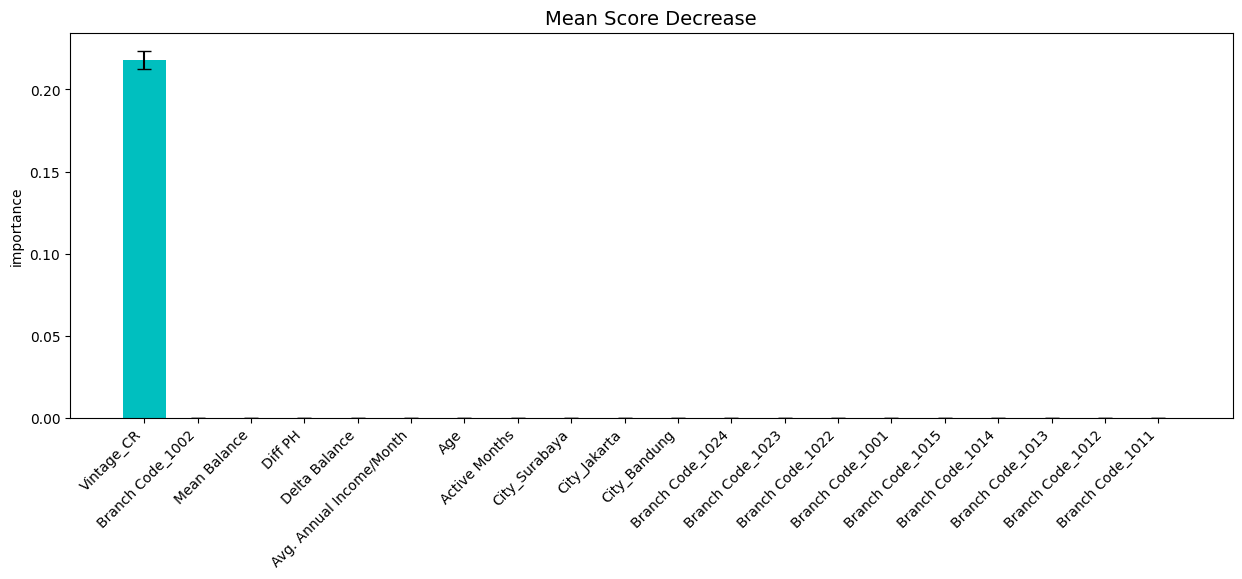

In [275]:
from jcopml.feature_importance import mean_score_decrease
df_imp1 = mean_score_decrease(X1_train, y1_train, grid, plot=True, topk=20)

Eksperimen 2

In [294]:
y2_pred = grid2.predict(X2_test)

In [296]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y2_test, y2_pred))
print('Recall:', metrics.recall_score(y2_test, y2_pred))
metrics.completeness_score

Accuracy: 0.8162185985015425
Recall: 0.3118811881188119


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [330]:
y2_pred_val = grid.predict(X2_val)
print('Accuracy:', metrics.accuracy_score(y2_val, y2_pred_val))
print('Recall:', metrics.recall_score(y2_val, y2_pred_val))
metrics.completeness_score

Accuracy: 0.8070059484467944
Recall: 0.26448362720403024


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

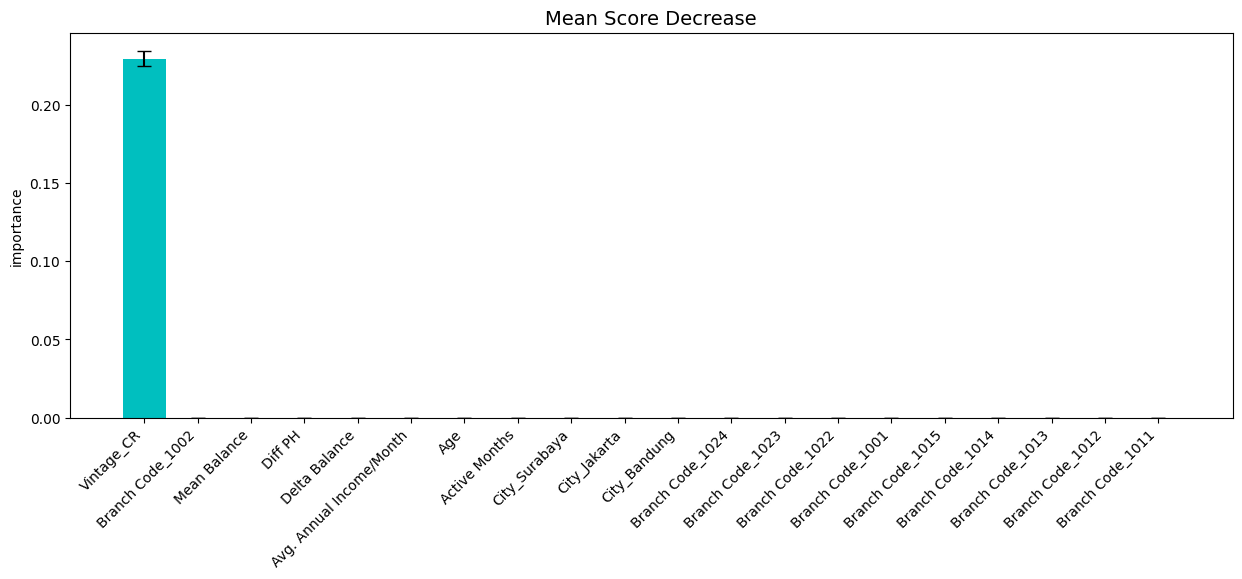

In [331]:
df_imp2 = mean_score_decrease(X2_train, y2_train, grid, plot=True, topk=20)

#### **2. Gradient Boosting**

Eksperimen 1

In [314]:
y11_pred = GB_Grid.predict(X1_test)

In [315]:
print('Accuracy:', metrics.accuracy_score(y1_test, y11_pred))
print('Recall:', metrics.recall_score(y1_test, y11_pred))
metrics.completeness_score

Accuracy: 0.5218157778757162
Recall: 0.8217821782178217


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [332]:
y11_pred_val = GB_Grid.predict(X1_val)

In [334]:
print('Accuracy:', metrics.accuracy_score(y1_val, y11_pred_val))
print('Recall:', metrics.recall_score(y1_val, y11_pred_val))
metrics.completeness_score

Accuracy: 0.5280898876404494
Recall: 0.8211586901763224


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

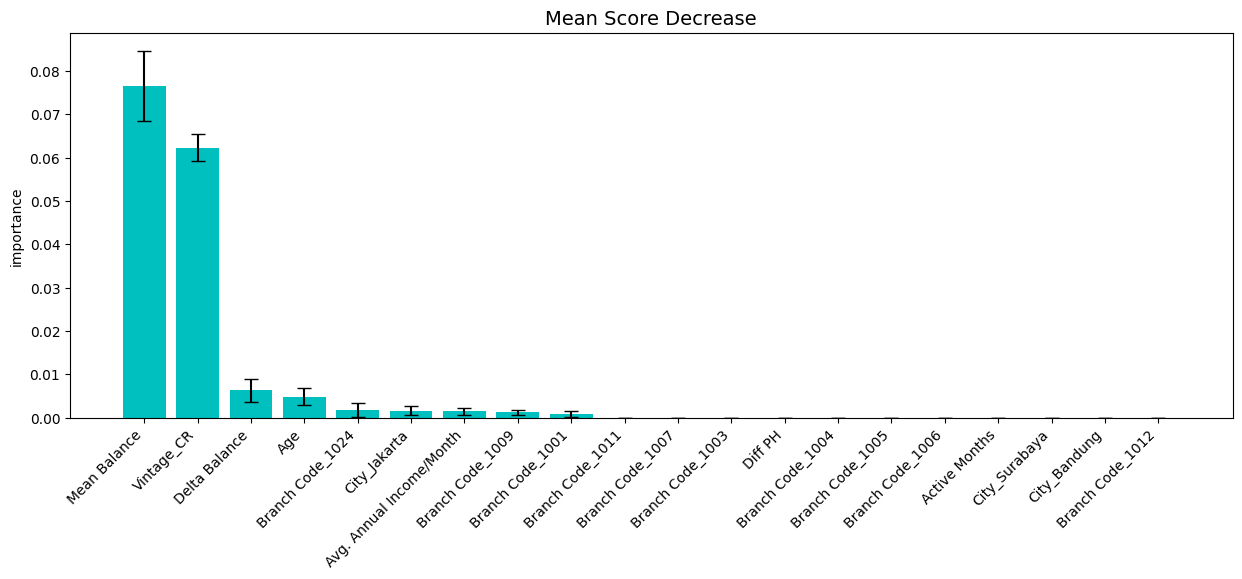

In [335]:
df_imp3 = mean_score_decrease(X2_train, y2_train, GB_Grid, plot=True, topk=20)

Eksperimen 2

In [340]:
y22_pred = GB_Grid2.predict(X2_test)

In [348]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y2_test, y22_pred))
print('Recall:', metrics.recall_score(y2_test, y22_pred))
metrics.completeness_score

Accuracy: 0.5301895107977083
Recall: 0.8316831683168316


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [341]:
y22_pred_val = GB_Grid2.predict(X2_val)

In [346]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y2_val, y22_pred_val))
print('Recall:', metrics.recall_score(y2_val, y22_pred_val))
metrics.completeness_score

Accuracy: 0.5155320555188367
Recall: 0.8136020151133502


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

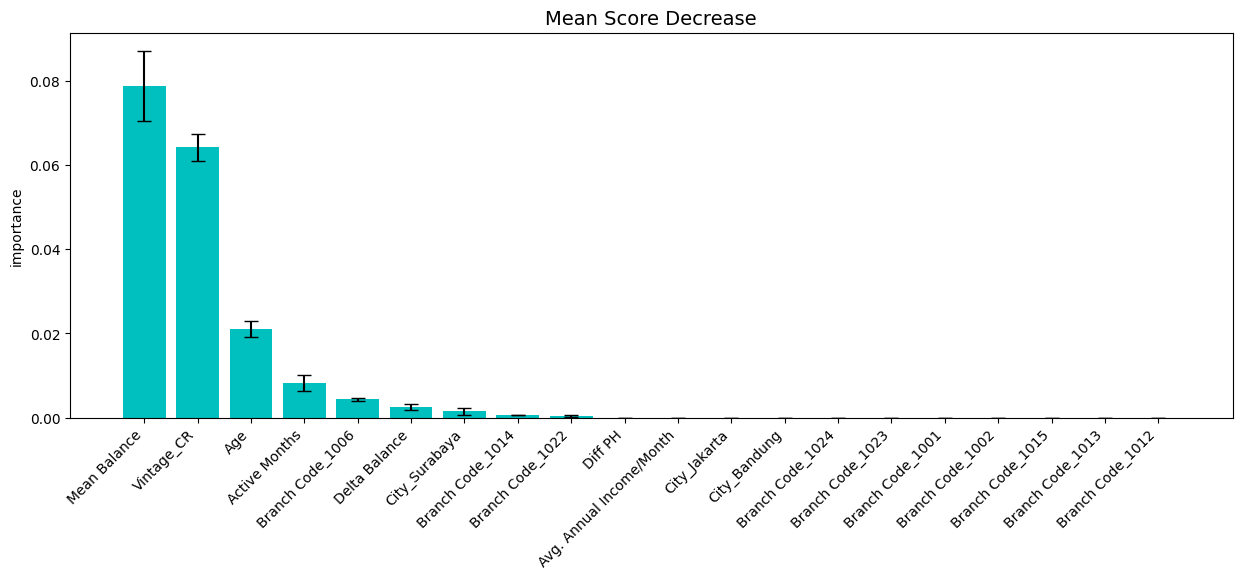

In [344]:
df_imp4 = mean_score_decrease(X2_train, y2_train, GB_Grid2, plot=True, topk=20)

#### **3. Random Forest**

Eksperimen 1

In [319]:
y12_pred = RF_Grid.predict(X1_test)

In [349]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y1_test, y12_pred))
print('Recall:', metrics.recall_score(y1_test, y12_pred))
metrics.completeness_score

Accuracy: 0.8082855883649185
Recall: 0.33993399339933994


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [350]:
y12_pred_val = RF_Grid.predict(X1_val)

In [352]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y1_val, y12_pred_val))
print('Recall:', metrics.recall_score(y1_val, y12_pred_val))
metrics.completeness_score

Accuracy: 0.9140779907468606
Recall: 0.6977329974811083


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

Eksperimen 2

In [353]:
y21_pred = RF_Grid2.predict(X2_test)

In [355]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y2_test, y21_pred))
print('Recall:', metrics.recall_score(y2_test, y21_pred))
metrics.completeness_score

Accuracy: 0.8113706478624945
Recall: 0.3333333333333333


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [356]:
y21_pred_val = RF_Grid2.predict(X2_val)

In [358]:
from sklearn import metrics
print('Accuracy:', metrics.accuracy_score(y2_val, y21_pred_val))
print('Recall:', metrics.recall_score(y2_val, y21_pred_val))
metrics.completeness_score

Accuracy: 0.913417052214144
Recall: 0.6876574307304786


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

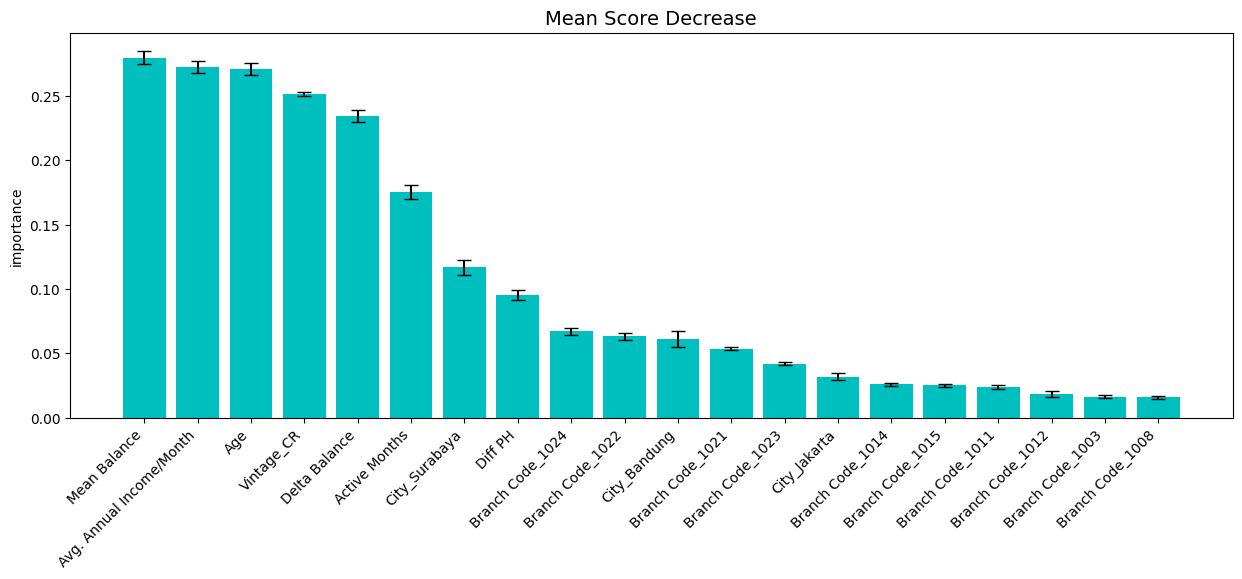

In [362]:
df_imp6 = mean_score_decrease(X2_train, y2_train, RF_Grid2, plot= True, topk=20)

# **Kesimpulan**

Model Random Forest mencapai akurasi tertinggi pada data testing sebesar 80% dan pada data validasi sebesar 70% dalam eksperimen 1 maupun eksperimen 2.

Dari 3 model machine learning yang telah dibangun, rata-rata memiliki accuracy di atas 60% namun memiliki recall di bawah 40%. Artinya, masih banyak nasabah yang sebenarnya berpotensi gagal bayar namun diprediksi tidak akan gagal bayar. Sehingga bisa disampaikan bahwa dalam iterasi pembangunan model kali ini, objektif yang diinginkan masih belum dapat tercapai.

Solusi pengembangan kedepannya yang bisa dilakukan di antaranya:

1. Memperbanyak sample (jumlah nasabah dgn asumsi dataset yang tersedia saat ini bukan total populasi nasabah)
2. Melakukan oversampling terhadap kelas minoritas (gagal bayar) agar pembangunan model tidak bias
3. Memperluas horizon waktu
4. Mencoba variasi variabel lainnya (menambah variabel baru, atau membuang variabel yang memiliki nilai importance rendah pada hasil terakhir)
5. Mencoba memperluas kombinasi hyperparameter dalam pembangunan model
6. Mencoba algoritma supervised machine learning lainnya